In [2]:
import numpy as np
import pandas as pd
from fastai.tabular.all import *
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Merge Wodify, SugarWOD and Strava Data

Starting where data_discovery_manipulation notebook left off, merge full data tables

#### The low_memory parameter, which is True by default, tells Pandas to only look at a few rows of data at a time to figure out what type of data is in each column. This means that Pandas can actually end up using different data type for different rows, which generally leads to data processing errors or model training problems later.

In [3]:
strava = pd.read_json('../observations/strava/activities.json')
sugarwod = pd.read_csv('../observations/sugarwod/workouts.csv', low_memory=False)
wodify_lifts = pd.read_excel('../observations/wodify/PerformanceResults.xlsx')
wodify_metcons = pd.read_excel('../observations/wodify/PerformanceResultsMetcons.xlsx')
wodify_prs = pd.read_excel('../observations/wodify/PerformanceResultsPRs.xlsx')

#### Make a 'date' column in each Dataframe of the same format 

In [4]:
strava['start_date_local'] = pd.to_datetime(strava['start_date_local'])
strava['start_time'] = strava['start_date_local'].dt.strftime('%H:%M:%S')

strava['date'] = strava['start_date_local'].dt.strftime('%Y-%m-%d')
strava = strava.drop(columns=['start_date_local'])

strava['strava_name'] = strava['name']
strava = strava.drop(columns=['name'])

sugarwod['date'] = pd.to_datetime(sugarwod['date'])
sugarwod['date'] = sugarwod['date'].dt.strftime('%Y-%m-%d')

wodify_lifts['date'] = wodify_lifts['Date'].dt.strftime('%Y-%m-%d')
wodify_lifts = wodify_lifts.drop(columns=['Date'])

wodify_metcons['date'] = wodify_metcons['Date'].dt.strftime('%Y-%m-%d')
wodify_metcons = wodify_metcons.drop(columns=['Date'])

wodify_prs['Peformance Result Date'] = pd.to_datetime(wodify_prs['Performance Result Date'])
wodify_prs['date'] = wodify_prs['Performance Result Date'].dt.strftime('%Y-%m-%d')
wodify_prs = wodify_prs.drop(columns=['Performance Result Date'])

#### Rename duplicate column names where merges would result in data loss

In [5]:
wodify_lifts['lift_component'] = wodify_lifts['Component']
wodify_lifts = wodify_lifts.drop(columns=['Component'])

wodify_metcons['metcon_component'] = wodify_metcons['Component']
wodify_metcons = wodify_metcons.drop(columns=['Component'])

wodify_prs['pr_component'] = wodify_prs['Component Name']
wodify_prs = wodify_prs.drop(columns=['Component Name'])

wodify_lifts['is_lift_pr'] = wodify_lifts['Is Personal Record']
wodify_lifts['lift_pr_description'] = wodify_lifts['Personal Record Description']
wodify_lifts = wodify_lifts.drop(columns=['Is Personal Record'])
wodify_lifts = wodify_lifts.drop(columns=['Personal Record Description'])

wodify_metcons['is_metcon_pr'] = wodify_metcons['Is Personal Record']
wodify_metcons['metcon_pr_description'] = wodify_metcons['Personal Record Description']
wodify_metcons = wodify_metcons.drop(columns=['Is Personal Record'])
wodify_metcons = wodify_metcons.drop(columns=['Personal Record Description'])

#### Text describing the WOD is in the 'description' column on SugarWOD and the 'Component Description' column of Wodify

#### Rename these so they will merge on concatenation: this is safe so long as there is one WOD performed per day

#### Rethink if there becomes a case where two different WODs are performed on the same day on different apps

In [6]:
wodify_metcons['wod'] = wodify_metcons['Component Description']
wodify_metcons = wodify_metcons.drop(columns=['Component Description'])

sugarwod['wod'] = sugarwod['description']
sugarwod = sugarwod.drop(columns=['description'])

#### Merge the dataframes on 'date' attribute: All the workout data for one day in each row

In [7]:
wodify_all = pd.concat([wodify_lifts, wodify_metcons, wodify_prs])

all_data = pd.concat([wodify_all, strava, sugarwod])

all_data.loc[all_data['date'] == '2023-01-10']

,Affiliate Name,Class Name,Result,Performance Result Type,Comment,From Weightlifting Total,date,lift_component,is_lift_pr,lift_pr_description,...,strava_name,title,best_result_raw,best_result_display,score_type,barbell_lift,set_details,notes,rx_or_scaled,pr
4,CrossFit Cove,Cove Fitness: Noon,1 x 5 @ 275 lbs,Weight,NaN,False,2023-01-10,Deadlift,True,PR by 20 lbs vs. 255 on 11/02/2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,CrossFit Cove,Cove Fitness: Noon,NaN,NaN,NaN,NaN,2023-01-10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,Cove Fitness: Noon,1 x 5 @ 275 lbs,NaN,NaN,NaN,2023-01-10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
all_data_by_date = all_data.groupby(all_data['date'], as_index=False).aggregate('first')

all_data_by_date.loc[all_data_by_date['date'] == '2023-01-10']

,date,Affiliate Name,Class Name,Result,Performance Result Type,Comment,From Weightlifting Total,lift_component,is_lift_pr,lift_pr_description,...,strava_name,title,best_result_raw,best_result_display,score_type,barbell_lift,set_details,notes,rx_or_scaled,pr
219,2023-01-10,CrossFit Cove,Cove Fitness: Noon,1 x 5 @ 275 lbs,Weight,NaN,False,Deadlift,True,PR by 20 lbs vs. 255 on 11/02/2022,...,None,None,NaN,None,None,None,None,None,None,None


# Data Manipulation

In [9]:
all_data_by_date.columns

Index(['date', 'Affiliate Name', 'Class Name', 'Result',
       'Performance Result Type', 'Comment', 'From Weightlifting Total',
       'lift_component', 'is_lift_pr', 'lift_pr_description', 'Component(2)',
       'Fully Formatted Result', 'Is Rx', 'Is Rx Plus', 'Result Type Label',
       'Full Comment', 'metcon_component', 'is_metcon_pr',
       'metcon_pr_description', 'wod', 'Rep Scheme',
       'Performance Result Comment', 'Personal Record Text',
       'Peformance Result Date', 'pr_component', 'resource_state', 'athlete',
       'distance', 'moving_time', 'elapsed_time', 'total_elevation_gain',
       'type', 'sport_type', 'id', 'start_date', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'map', 'trainer', 'commute', 'manual', 'private',
       'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng',
       'average_speed', 'max_sp

## Too many columns to handle initially

### Slim Down to ten most relevant columns for initial analysis
### Add additional columns into future analyses

The most important column is the dependent variable, the one we want to predict.

Choosing a model metric is the next most important. Think carefully about the metric(s) that measure quality in your case. 

1. I want to predict sport_type for a workout. This is my dependent variable.

2. I remove all text fields from the data to be analyzed, most importantly 'wod', because they are best analyzed by adding deep learning

3. Remove fields specific to only one sport type (i.e. scaled vs Rx is specific to crossfit)

In [43]:
df2 = all_data_by_date.filter(['date', 'start_time', 'sport_type', 'moving_time', 'elapsed_time', 'average_heartrate', 'max_heartrate', 'max_speed', 'average_speed', 'distance'], axis=1)

In [44]:
dep_var = 'sport_type'

#### Using Fast.ai, replace every date column with a set of date metadata columns, such as holiday, day of week, and month. 
#### These columns provide categorical data that we suspect will be useful.

In [19]:
all_data_by_date = add_datepart(all_data_by_date, 'date')

# March 28th, 2023 and Earlier ...

#### I have let read_csv and read_excel infer data types up until now

In [298]:
all_data_by_date[all_data_by_date.columns].dtypes

date                       object
Affiliate Name             object
Class Name                 object
Result                     object
Performance Result Type    object
                            ...  
barbell_lift               object
set_details                object
notes                      object
rx_or_scaled               object
pr                         object
Length: 86, dtype: object

#### I use convert_dtypes to convert columns back to their intended data types

In [299]:
adbd = all_data_by_date.convert_dtypes()
adbd[adbd.columns].dtypes

date                       string
Affiliate Name             string
Class Name                 string
Result                     string
Performance Result Type    string
                            ...  
barbell_lift               string
set_details                string
notes                      string
rx_or_scaled               string
pr                         string
Length: 86, dtype: object

In [300]:
adbd['start_date']

0      2021-07-26T21:01:22Z
1      2021-08-04T21:35:51Z
2      2021-08-10T21:08:33Z
3      2021-08-14T11:36:56Z
4      2021-08-18T20:56:44Z
               ...         
228                    <NA>
229                    <NA>
230                    <NA>
231                    <NA>
232                    <NA>
Name: start_date, Length: 233, dtype: string

In [301]:
adbd['start_time'].isna().sum()

37

#### TODO: Work to be done sorting out how to handle time: start time, end time, duration

#### TODO: More processing on the 'wod' column to determine what the workout is

In [302]:
adbd['wod'].head()

0    <NA>
1    <NA>
2    <NA>
3    <NA>
4    <NA>
Name: wod, dtype: string

### The smartest first step: 

### Use Random Forest to determine Feature Importance

#### First, do some data cleaning

In [303]:
adbd.isna().sum()

date                         0
Affiliate Name             204
Class Name                 204
Result                     223
Performance Result Type    223
                          ... 
barbell_lift               220
set_details                163
notes                      195
rx_or_scaled               163
pr                         221
Length: 86, dtype: int64

In [304]:
# how many rows in the dataframe?
adbd.shape[0]

233

#### Filling in missing values with the most common column value does not make sense for this data

#### Some columns are irrelevant for certain records: 

#### Affiliate Name in the case of a Bike Ride, Notes are specific to each WOD and may be left empty,

#### PR should not be filled with PR, rx_or_scaled should not be filled with SCALED

#### These could be boolean values? is_pr, is_rx, is_scaled

### TODO: More work to be done finding the best way to fill missing values

#### For the sake of proceeding today, fill in NaN with most common values in each column

#### After dropping columns where the most common value is NA

#### Also drop Athlete and Map because their data type is a dictionary

In [305]:
adbd.drop(inplace=True, columns=['Comment', 'metcon_pr_description', 'Performance Result Comment', 'location_city', 'location_state', 'location_country', 'gear_id', 'athlete', 'map', 'workout_type'])

In [306]:
# It appears that in order to fill N/A values, the dataframe from which data will be pulled to fill empty cells

# must be of the same shape as the receiving dataframe. 

# In this cell I make a dataframe out of the Mode values of each column. As 'modes_df' it is a one column dataframe

# with an index of all the column names. I transpose it to turn the index into column names and the column into a row

# then I duplicate that row until the dataframe is the size of the receiving dataframe

modes = adbd.mode().iloc[0]
modes_dict = modes.to_dict()
modes_df = pd.DataFrame(modes)
modes_df = modes_df.transpose()
modes_df = modes_df.append([modes_df.iloc[0]]*(adbd.shape[0]-1), ignore_index=True)
modes_df

/var/folders/qw/d48b51n13sxcgsznf127fvj40000gn/T/ipykernel_71286/1436181709.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modes_df = modes_df.append([modes_df.iloc[0]]*(adbd.shape[0]-1), ignore_index=True)


,date,Affiliate Name,Class Name,Result,Performance Result Type,From Weightlifting Total,lift_component,is_lift_pr,lift_pr_description,Component(2),...,strava_name,title,best_result_raw,best_result_display,score_type,barbell_lift,set_details,notes,rx_or_scaled,pr
0,2021-07-26,CrossFit Cove,Cove Fitness: 7:00 AM,1 x 1 @ 135 lbs,Weight,False,Deadlift,False,PR by 20 lbs vs. 255 on 11/02/2022,220,...,Morning Crossfit,For Time,125.0,125,Time,Bench Press,"[{""reps"":120}]",95 lb barbell,SCALED,PR
1,2021-07-26,CrossFit Cove,Cove Fitness: 7:00 AM,1 x 1 @ 135 lbs,Weight,False,Deadlift,False,PR by 20 lbs vs. 255 on 11/02/2022,220,...,Morning Crossfit,For Time,125.0,125,Time,Bench Press,"[{""reps"":120}]",95 lb barbell,SCALED,PR
2,2021-07-26,CrossFit Cove,Cove Fitness: 7:00 AM,1 x 1 @ 135 lbs,Weight,False,Deadlift,False,PR by 20 lbs vs. 255 on 11/02/2022,220,...,Morning Crossfit,For Time,125.0,125,Time,Bench Press,"[{""reps"":120}]",95 lb barbell,SCALED,PR
3,2021-07-26,CrossFit Cove,Cove Fitness: 7:00 AM,1 x 1 @ 135 lbs,Weight,False,Deadlift,False,PR by 20 lbs vs. 255 on 11/02/2022,220,...,Morning Crossfit,For Time,125.0,125,Time,Bench Press,"[{""reps"":120}]",95 lb barbell,SCALED,PR
4,2021-07-26,CrossFit Cove,Cove Fitness: 7:00 AM,1 x 1 @ 135 lbs,Weight,False,Deadlift,False,PR by 20 lbs vs. 255 on 11/02/2022,220,...,Morning Crossfit,For Time,125.0,125,Time,Bench Press,"[{""reps"":120}]",95 lb barbell,SCALED,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2021-07-26,CrossFit Cove,Cove Fitness: 7:00 AM,1 x 1 @ 135 lbs,Weight,False,Deadlift,False,PR by 20 lbs vs. 255 on 11/02/2022,220,...,Morning Crossfit,For Time,125.0,125,Time,Bench Press,"[{""reps"":120}]",95 lb barbell,SCALED,PR
229,2021-07-26,CrossFit Cove,Cove Fitness: 7:00 AM,1 x 1 @ 135 lbs,Weight,False,Deadlift,False,PR by 20 lbs vs. 255 on 11/02/2022,220,...,Morning Crossfit,For Time,125.0,125,Time,Bench Press,"[{""reps"":120}]",95 lb barbell,SCALED,PR
230,2021-07-26,CrossFit Cove,Cove Fitness: 7:00 AM,1 x 1 @ 135 lbs,Weight,False,Deadlift,False,PR by 20 lbs vs. 255 on 11/02/2022,220,...,Morning Crossfit,For Time,125.0,125,Time,Bench Press,"[{""reps"":120}]",95 lb barbell,SCALED,PR
231,2021-07-26,CrossFit Cove,Cove Fitness: 7:00 AM,1 x 1 @ 135 lbs,Weight,False,Deadlift,False,PR by 20 lbs vs. 255 on 11/02/2022,220,...,Morning Crossfit,For Time,125.0,125,Time,Bench Press,"[{""reps"":120}]",95 lb barbell,SCALED,PR


In [307]:
adbd = adbd.fillna(value=modes_df)

In [308]:
adbd.isna().sum()

date                       0
Affiliate Name             0
Class Name                 0
Result                     0
Performance Result Type    0
                          ..
barbell_lift               0
set_details                0
notes                      0
rx_or_scaled               0
pr                         0
Length: 77, dtype: int64

In [372]:
adbd.columns

Index(['date', 'Affiliate Name', 'Class Name', 'Result',
       'Performance Result Type', 'From Weightlifting Total', 'lift_component',
       'is_lift_pr', 'lift_pr_description', 'Component(2)',
       'Fully Formatted Result', 'Is Rx', 'Is Rx Plus', 'Result Type Label',
       'Full Comment', 'metcon_component', 'is_metcon_pr', 'wod', 'Rep Scheme',
       'Personal Record Text', 'Peformance Result Date', 'pr_component',
       'resource_state', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'sport_type', 'id', 'start_date',
       'timezone', 'utc_offset', 'achievement_count', 'kudos_count',
       'comment_count', 'athlete_count', 'photo_count', 'trainer', 'commute',
       'manual', 'private', 'visibility', 'flagged', 'start_latlng',
       'end_latlng', 'average_speed', 'max_speed', 'has_heartrate',
       'average_heartrate', 'max_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'upload_id', 'upload_id_str',
       'exte

### use moving_time, type, start_time, is_metcon_pr, pr to predict average_heartrate and max_heartrate

#### create independent (predictors) and dependent (target) variables as PyTorch tensors

#### to do this, first create a new dataframe with the columns I want to work with

#### ensure column values are all numeric

In [407]:
sub_table = adbd[['moving_time', 'type', 'is_metcon_pr', 'pr', 'start_time', 'average_heartrate', 'max_heartrate']].copy()

# Convert moving_time from object to int64

sub_table['moving_time'] = sub_table['moving_time'].astype('int64')

# Convert the start_time column to the number of seconds

sub_table['start_time'] = pd.to_datetime(sub_table['start_time'])

sub_table['start_time'] = (sub_table['start_time'].dt.hour*60+sub_table['start_time'].dt.minute)*60 + sub_table['start_time'].dt.second

# Convert type column to integers representing each possible value

# sub_table = pd.get_dummies(sub_table, columns=["type"])

sub_table['type'] = pd.Categorical(sub_table.type)

# convert pr column to boolean based on empty string 

d = {'PR': True, '': False}

sub_table['pr'] = sub_table['pr'].map(d)

sub_table['pr'] = pd.Categorical(sub_table.pr)

sub_table['is_metcon_pr'] = pd.Categorical(sub_table.is_metcon_pr)

In [408]:
# sub_table.type.head()

sub_table.type.cat.codes.head()

0    6
1    3
2    3
3    2
4    3
dtype: int8

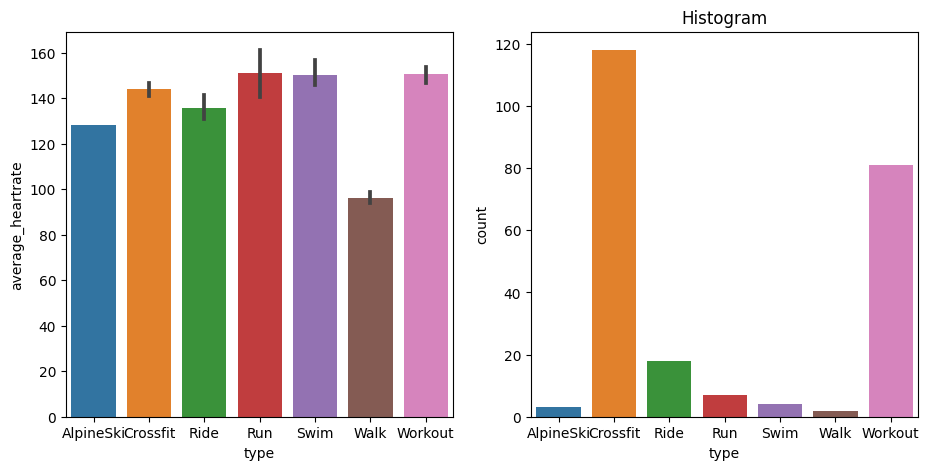

In [403]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=sub_table, y="average_heartrate", x="type", ax=axs[0]).set(title="")
sns.countplot(data=sub_table, x="type", ax=axs[1]).set(title="Histogram");

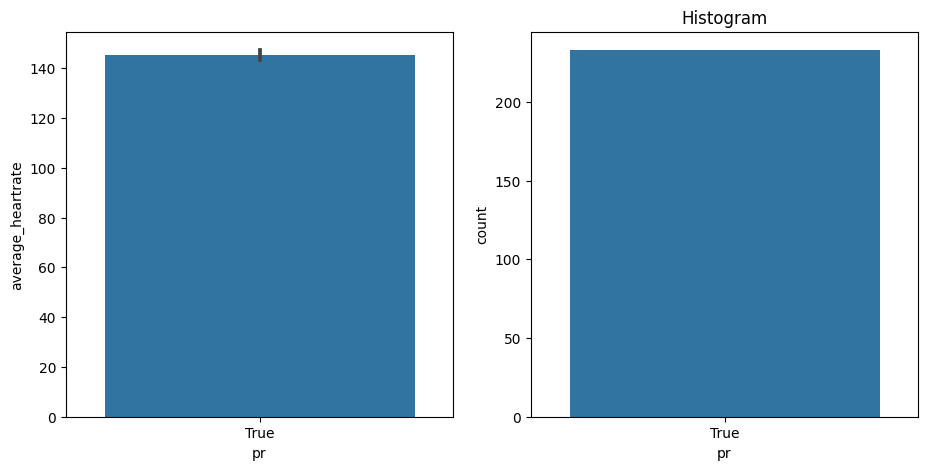

In [404]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=sub_table, y="average_heartrate", x="pr", ax=axs[0]).set(title="")
sns.countplot(data=sub_table, x="pr", ax=axs[1]).set(title="Histogram");

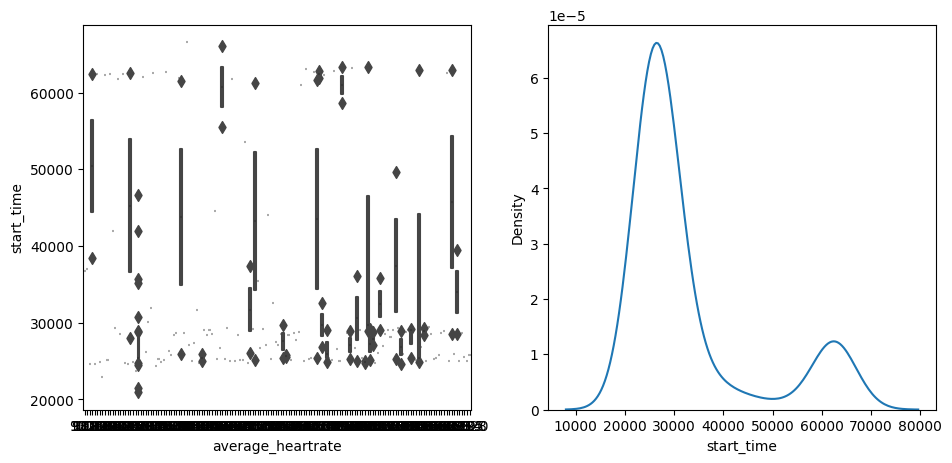

In [406]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=sub_table, x="average_heartrate", y="start_time", ax=axs[0])
sns.kdeplot(data=sub_table, x="start_time", ax=axs[1]);

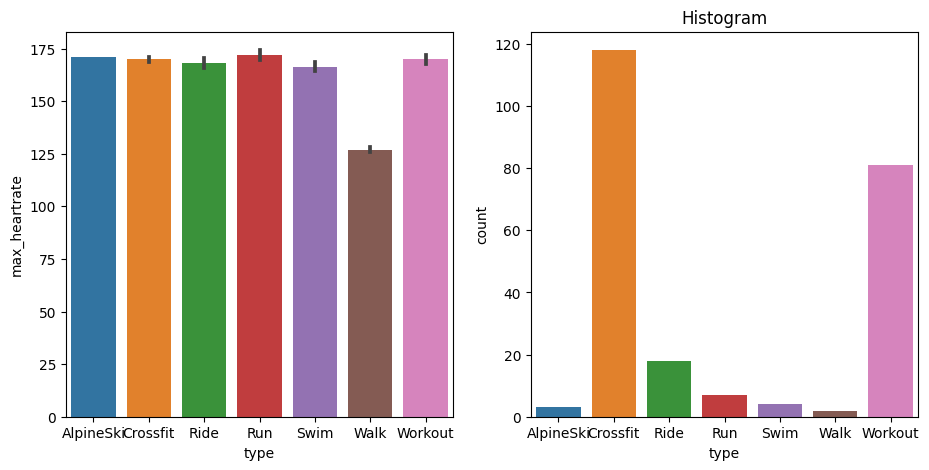

In [409]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=sub_table, y="max_heartrate", x="type", ax=axs[0]).set(title="")
sns.countplot(data=sub_table, x="type", ax=axs[1]).set(title="Histogram");

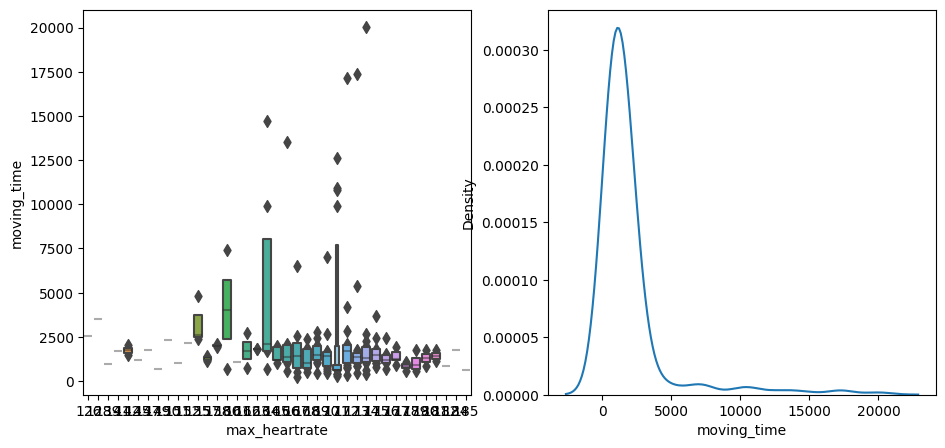

In [411]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=sub_table, x="max_heartrate", y="moving_time", ax=axs[0])
sns.kdeplot(data=sub_table, x="moving_time", ax=axs[1]);

### Create a OneR Model

#### How to create a OneR for Average Heartrate from Type (Categorical Variable)?

#### Create a Train and Test Split and replace categorical variables with their integer codes

In [420]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

# Define which columns are categorical and which are continuous
# Define the dependent variable

conts = ['moving_time', 'start_time', 'max_heartrate']
cats = ['type', 'pr', 'is_metcon_pr']
dep = 'average_heartrate'

trn_df,val_df = train_test_split(sub_table, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

#### Separate into groups the independent variables (the x variables) and dependent (the y variable) in the train and test sets

In [421]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

#### Measure the similarity of rows by taking the standard deviation of the dependent variable

#### If it's higher, then it means the rows are more different to each other. 

In [422]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

#### calculate the score for a split by adding up the scores for the "left hand side" (lhs) and "right hand side" (rhs)

In [423]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

#### The 'impurity' score for a split on type

In [424]:
score(trn_xs['type'], trn_y, 0.5)

16.907257919567588

#### Pretty bad. I can, however, ask the machine to find the best split point on 'type'

#### To start, make a list of all the unique values of the 'type' column

In [425]:
col = trn_xs['type']
unq = col.unique()
unq.sort()
unq

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

#### Find where impurity score is lowest

In [429]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

5

In [432]:
sub_table.type.cat.categories

Index(['AlpineSki', 'Crossfit', 'Ride', 'Run', 'Swim', 'Walk', 'Workout'], dtype='string')

#### So whether or not the workout type is 'Walk' is the largest determining factor

#### To try all the columns for which provides the best binary split:

In [433]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

In [434]:
cols = cats+conts

{o:min_col(trn_df, o) for o in cols}

{'type': (5, 16.77631997595778),
 'pr': (0, 17.11155346860214),
 'is_metcon_pr': (0, 17.11155346860214),
 'moving_time': (1928, 15.763039170079708),
 'start_time': (25353, 16.417651586325533),
 'max_heartrate': (171, 14.408921458769045)}